<a href="https://colab.research.google.com/github/Gmgiorjiani/BrainArt/blob/main/modelsNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm

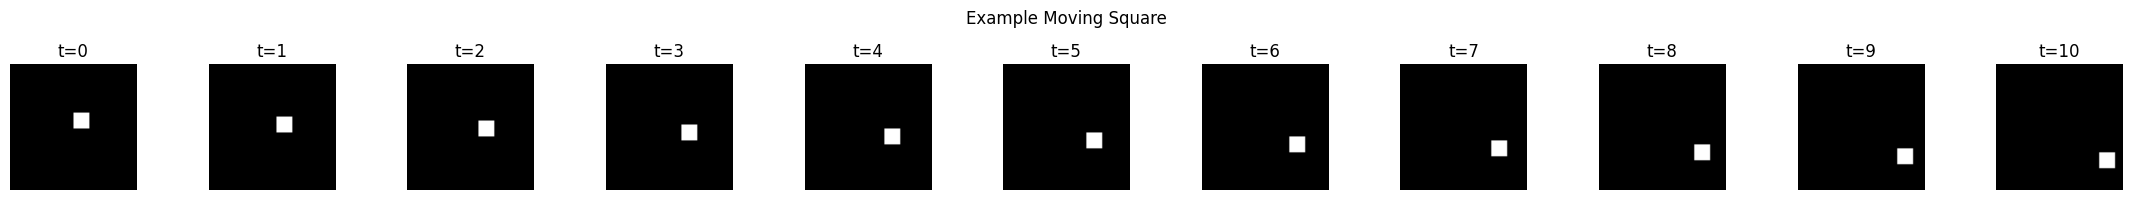

In [ ]:
# 🔬 PhD Lab Notebook: Video Prediction (Feedforward vs Recurrent vs Feedback)

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

# Enable mixed precision for GPU optimization
#from tf.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

# ---------------------------
# 🔀 Reproducibility
# ---------------------------
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# ---------------------------
# 📦 Synthetic Dataset
# ---------------------------
def generate_moving_shape_seq(seq_len=11, img_size=64, shape_size=8):
    canvas = np.zeros((seq_len, img_size, img_size, 3), dtype=np.float32)
    x, y = np.random.randint(0, img_size - shape_size, 2)
    dx, dy = np.random.choice([-1, 1]), np.random.choice([-1, 1])
    for t in range(seq_len):
        canvas[t] = 0
        canvas[t, y:y+shape_size, x:x+shape_size] = 1.0
        x += dx * 2
        y += dy * 2
        x = np.clip(x, 0, img_size - shape_size)
        y = np.clip(y, 0, img_size - shape_size)
    return canvas

def generate_dataset(num_sequences=1000):
    X, Y = [], []
    for _ in range(num_sequences):
        seq = generate_moving_shape_seq()
        X.append(seq[:10])  # input
        Y.append(seq[10])   # target
    return np.array(X), np.array(Y)

X_train, Y_train = generate_dataset(5000)
X_val, Y_val = generate_dataset(500)
X_test, Y_test = generate_dataset(500)

# ---------------------------
# 🖼️ Visualize Sequences
# ---------------------------
def plot_sequence(sequence, title="Sequence"):
    seq_len = sequence.shape[0]
    fig, axes = plt.subplots(1, seq_len, figsize=(seq_len * 2, 2))
    for i in range(seq_len):
        axes[i].imshow(sequence[i])
        axes[i].axis('off')
        axes[i].set_title(f"t={i}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# View one example
plot_sequence(generate_moving_shape_seq(), title="Example Moving Square")

In [ ]:
# ---------------------------
# 🧐 Model Definitions
# ---------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ConvLSTM2D, Conv2D, Add

def build_model_feedforward(input_shape=(10, 64, 64, 3)):
    inputs = Input(shape=input_shape)
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv3D(3, (1, 1, 1), padding='same', activation='sigmoid')(x)
    output = x[:, -1]
    return Model(inputs, output)

def build_model_convLSTM(input_shape=(10, 64, 64, 3)):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(128, (3, 3), padding='same', return_sequences=True, activation='relu')(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    return Model(inputs, output)


def build_model_feedback(input_shape=(10, 64, 64, 3)):
    inputs = Input(shape=input_shape)

    # ConvLSTM stack (all return_sequences=True!)
    x1 = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu')(inputs)
    x1 = BatchNormalization()(x1)

    x2 = ConvLSTM2D(128, (3, 3), padding='same', return_sequences=True, activation='relu')(x1)
    x2 = BatchNormalization()(x2)

    x3 = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu')(x2)
    x3 = BatchNormalization()(x3)

    # ⚠️ Use TimeDistributed(Conv2D) instead of Conv3D to avoid the time-dimension mixup
    from tensorflow.keras.layers import TimeDistributed, Conv2D

    x1_proj = TimeDistributed(Conv2D(64, (1, 1), padding='same'))(x1)
    x2_proj = TimeDistributed(Conv2D(64, (1, 1), padding='same'))(x2)
    x3_proj = TimeDistributed(Conv2D(64, (1, 1), padding='same'))(x3)

    feedback = Add()([x1_proj, x2_proj, x3_proj])

    # Final ConvLSTM to collapse time
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False, activation='relu')(feedback)
    x = BatchNormalization()(x)

    output = Conv2D(3, (3, 3), padding='same', activation='sigmoid', dtype='float32')(x)

    return Model(inputs, output)


model_registry = {
    "feedforward": build_model_feedforward,
    "conv_lstm": build_model_convLSTM,
    "feedback": build_model_feedback
}

In [ ]:
# ---------------------------
# 📊 Training + Evaluation
# ---------------------------

def train_model(name, X_train, Y_train, X_val, Y_val, epochs=20, batch_size=16):
    print(f"\n📚 Training model: {name}")
    model_fn = model_registry[name]
    model = model_fn(input_shape=X_train.shape[1:])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    checkpoint_path = f"best_{name}.h5"
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
            TqdmCallback(verbose=1)
        ],
        verbose=0
    )
    print(f"✅ Best model saved to {checkpoint_path}")
    return model, history

def autoregressive_loop(model, initial_seq, num_preds):
    preds = []
    x = initial_seq.copy()
    for _ in range(num_preds):
        y = model.predict(x)
        preds.append(y[0])
        x = tf.concat([x[:, 1:], tf.expand_dims(y, axis=1)], axis=1)
    return np.stack(preds)

import tensorflow.image as tfi

def compute_framewise_ssim(y_true, y_pred):
    return np.mean([
        tfi.ssim(y_true[i], y_pred[i], max_val=1.0).numpy()
        for i in range(len(y_true))
    ])

def run_experiment(model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    model, history = train_model(model_name, X_train, Y_train, X_val, Y_val)
    test_seq = X_test[0:1]
    gt_future = [Y_test[0]]
    preds = autoregressive_loop(model, test_seq, num_preds=1)
    ssim = compute_framewise_ssim(np.array(gt_future), preds)
    print(f"📊 SSIM for {model_name}: {ssim:.4f}")
    # Plot comparison
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(test_seq[0, -1])
    axs[0].set_title("Last Input")
    axs[1].imshow(preds[0])
    axs[1].set_title("Prediction")
    axs[2].imshow(gt_future[0])
    axs[2].set_title("Ground Truth")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"Prediction result for {model_name}")
    plt.tight_layout()
    plt.show()

# Run all three models
#for name in ["feedforward", "conv_lstm", "feedback"]:
#    run_experiment(name, X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [ ]:
# Run all three models
run_experiment("feedback", X_train, Y_train, X_val, Y_val, X_test, Y_test)



📚 Training model: feedback


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]